In [ ]:
!pip uninstall -y transformers tokenizers
!pip install transformers==4.40.2 tokenizers==0.19.1

Found existing installation: transformers 4.57.1
Uninstalling transformers-4.57.1:
  Successfully uninstalled transformers-4.57.1
Found existing installation: tokenizers 0.22.1
Uninstalling tokenizers-0.22.1:
  Successfully uninstalled tokenizers-0.22.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 78.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 98.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 5.1.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.40.2 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import transformers
print(transformers.__version__)  # should show 4.40.2

from transformers import BertTokenizer, BertForNextSentencePrediction, Trainer, TrainingArguments
print("✅ Imports successful")

4.40.2


RuntimeError: Failed to import transformers.trainer because of the following error (look up to see its traceback):
cannot import name 'EncoderDecoderCache' from 'transformers' (/usr/local/lib/python3.12/dist-packages/transformers/__init__.py)

In [ ]:
# -----------------------------
# BERT NSP Manual Training in PyTorch
# -----------------------------

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForNextSentencePrediction, AdamW
import pandas as pd

# Load dataset
df = pd.read_csv("/content/nsp_dataset.csv")

# Dataset class
class NSPDataset(Dataset):
    def __init__(self, sentences_a, sentences_b, labels, tokenizer, max_len=64):
        self.sentences_a = sentences_a
        self.sentences_b = sentences_b
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        a = str(self.sentences_a[idx])
        b = str(self.sentences_b[idx])
        encoding = self.tokenizer(a, b, truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Initialize tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForNextSentencePrediction.from_pretrained("bert-base-uncased")

# Prepare DataLoader
dataset = NSPDataset(df['sentence_a'], df['sentence_b'], df['label'], tokenizer)
loader = DataLoader(dataset, batch_size=8, shuffle=True)

# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training loop (manual)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

for epoch in range(4):  # 2 epochs
    total_loss = 0
    for batch in loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1} Loss: {total_loss/len(loader):.4f}")

print("✅ Training finished!")

# Prediction function
def predict_nsp(sent_a, sent_b):
    model.eval()
    with torch.no_grad():
        encoding = tokenizer(sent_a, sent_b, return_tensors='pt')
        encoding = {k:v.to(device) for k,v in encoding.items()}
        logits = model(**encoding).logits
        probs = torch.softmax(logits, dim=1)
        pred = "Is Next Sentence ✅" if probs[0][0] > probs[0][1] else "Not Next Sentence ❌"
        print(f"\nSentence A: {sent_a}")
        print(f"Sentence B: {sent_b}")
        print(f"Prediction: {pred} (IsNext={probs[0][0]:.2f}, NotNext={probs[0][1]:.2f})")

# Test
predict_nsp("She studied all night for her exams.", "The teacher explained the lesson clearly.")
predict_nsp("It rained heavily throughout the night.", "He ordered a burger with fries.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 Loss: 0.6823
Epoch 2 Loss: 0.2285
Epoch 3 Loss: 0.0711
Epoch 4 Loss: 0.0014
✅ Training finished!

Sentence A: She studied all night for her exams.
Sentence B: The teacher explained the lesson clearly.
Prediction: Is Next Sentence ✅ (IsNext=1.00, NotNext=0.00)

Sentence A: It rained heavily throughout the night.
Sentence B: He ordered a burger with fries.
Prediction: Not Next Sentence ❌ (IsNext=0.00, NotNext=1.00)


In [ ]:
# Evaluation after training
model.eval()
total_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for batch in loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        preds = torch.argmax(outputs.logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

final_loss = total_loss / len(loader)
accuracy = correct / total

print(f"✅ Evaluation Complete | Loss: {final_loss:.4f} | Accuracy: {accuracy:.4f}")

✅ Evaluation Complete | Loss: 0.0007 | Accuracy: 1.0000


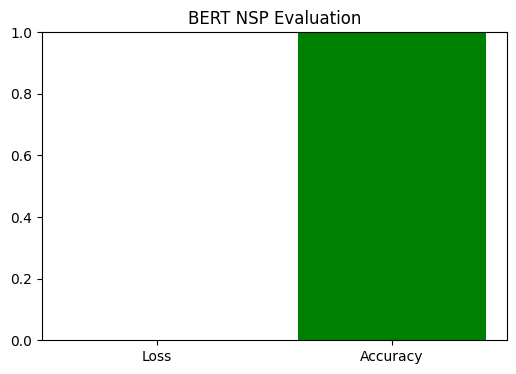

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.bar(["Loss", "Accuracy"], [final_loss, accuracy], color=["red", "green"])
plt.title("BERT NSP Evaluation")
plt.ylim(0,1)
plt.show()

<Figure size 500x500 with 0 Axes>

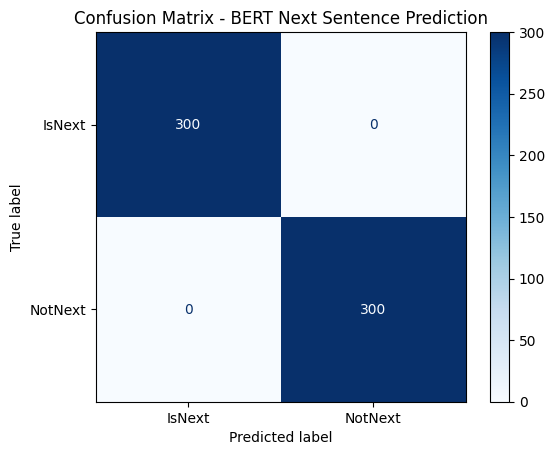

Confusion Matrix:
 [[300   0]
 [  0 300]]


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# ---------------------------
# Collect all predictions & labels
# ---------------------------
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ---------------------------
# Compute Confusion Matrix
# ---------------------------
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["IsNext", "NotNext"])

plt.figure(figsize=(5,5))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - BERT Next Sentence Prediction")
plt.show()

# Optional: Print confusion matrix values
print("Confusion Matrix:\n", cm)

In [ ]:
# Create a folder to save the model
save_path = "./bert_nsp_model"
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

print(f"✅ Model and tokenizer saved to {save_path}")

✅ Model and tokenizer saved to ./bert_nsp_model


In [ ]:
import torch
from transformers import BertTokenizer, BertForNextSentencePrediction

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Path to your saved model
model_path = "/content/drive/MyDrive/bert_nsp_model"

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForNextSentencePrediction.from_pretrained(model_path)
model.to(device)
model.eval()

print("✅ Model loaded successfully and moved to:", device)

✅ Model loaded successfully and moved to: cpu


In [ ]:
def predict_nsp(sent_a, sent_b):
    encoding = tokenizer(sent_a, sent_b, return_tensors='pt')
    encoding = {k: v.to(device) for k, v in encoding.items()}

    with torch.no_grad():
        outputs = model(**encoding)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)
        pred_label = torch.argmax(probs, dim=1).item()

    result = "Is Next Sentence ✅" if pred_label == 0 else "Not Next Sentence ❌"
    print(f"\nSentence A: {sent_a}")
    print(f"Sentence B: {sent_b}")
    print(f"Prediction: {result}")
    print(f"Confidence → IsNext: {probs[0][0]:.4f}, NotNext: {probs[0][1]:.4f}")

In [ ]:
# Test 1: Coherent sentences
predict_nsp("She finished her dinner.", "Then she started watching a movie.")

# Test 2: Unrelated sentences
predict_nsp("It was raining outside.", "I love programming in Python.")

# Test 3: Another positive pair
predict_nsp("The sun rises in the east.", "It gives light and warmth to the earth.")


Sentence A: She finished her dinner.
Sentence B: Then she started watching a movie.
Prediction: Not Next Sentence ❌
Confidence → IsNext: 0.0128, NotNext: 0.9872

Sentence A: It was raining outside.
Sentence B: I love programming in Python.
Prediction: Not Next Sentence ❌
Confidence → IsNext: 0.0087, NotNext: 0.9913

Sentence A: The sun rises in the east.
Sentence B: It gives light and warmth to the earth.
Prediction: Is Next Sentence ✅
Confidence → IsNext: 0.9969, NotNext: 0.0031


In [ ]:
!pip install streamlit pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 114.1 MB/s eta 0:00:00


# Main to run

In [ ]:
%%writefile app.py
import streamlit as st
import torch
from transformers import BertTokenizer, BertForNextSentencePrediction

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model and tokenizer
@st.cache_resource  # Prevents reloading on every Streamlit refresh
def load_model():
    tokenizer = BertTokenizer.from_pretrained("/content/drive/MyDrive/bert_nsp_model")
    model = BertForNextSentencePrediction.from_pretrained("/content/drive/MyDrive/bert_nsp_model")
    model.to(device)
    model.eval()
    return tokenizer, model

tokenizer, model = load_model()

# Streamlit UI
st.title("🧠 BERT Next Sentence Prediction")
st.write("Enter two sentences to see if the second logically follows the first.")

sentence_a = st.text_area("**Sentence A:**", placeholder="Type the first sentence...")
sentence_b = st.text_area("**Sentence B:**", placeholder="Type the second sentence...")

if st.button("🔍 Predict"):
    if sentence_a.strip() == "" or sentence_b.strip() == "":
        st.warning("⚠️ Please enter both sentences before predicting.")
    else:
        with torch.no_grad():
            encoding = tokenizer(sentence_a, sentence_b, return_tensors='pt')
            encoding = {k: v.to(device) for k, v in encoding.items()}
            logits = model(**encoding).logits
            probs = torch.softmax(logits, dim=1)
            pred_label = torch.argmax(probs, dim=1).item()

            result = "✅ **Is Next Sentence**" if pred_label == 0 else "❌ **Not Next Sentence**"
            st.subheader(result)
            st.write(f"**Confidence:** IsNext={probs[0][0]:.2f}, NotNext={probs[0][1]:.2f}")

Writing app.py


In [ ]:
!ngrok authtoken 34Tehz3OVgxar51I3cK2ahcs0mB_Asq1qPX7xCNDeYZ197N5

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from pyngrok import ngrok

# Kill any previous tunnels
ngrok.kill()

# Start Streamlit app (ensure app.py exists in /content)
get_ipython().system_raw("streamlit run app.py &")

In [ ]:
from pyngrok import ngrok

# Kill old tunnels
ngrok.kill()

# Run Streamlit app
get_ipython().system_raw("streamlit run app.py &")

# Create public link (✅ correct version)
public_url = ngrok.connect(8501, "http")
public_url

<NgrokTunnel: "https://overtight-evia-hypercyanotic.ngrok-free.dev" -> "http://localhost:8501">

In [ ]:
from pyngrok import ngrok
ngrok.kill()

In [ ]:
!nohup streamlit run app.py --server.port 8501 --server.address 0.0.0.0 >/content/logs.txt 2>&1 &

In [ ]:
from pyngrok import ngrok
public_url = ngrok.connect(addr="8501")
print("🚀 Streamlit app URL:", public_url)

🚀 Streamlit app URL: NgrokTunnel: "https://overtight-evia-hypercyanotic.ngrok-free.dev" -> "http://localhost:8501"


In [ ]:
!tail -n 40 /content/logs.txt

In [ ]:
!ls -R ./bert_nsp_model

./bert_nsp_model:
config.json	   special_tokens_map.json  vocab.txt
model.safetensors  tokenizer_config.json


In [ ]:
from sklearn.metrics import confusion_matrix
import torch

# Switch model to evaluation mode
model.eval()
total_loss = 0
correct = 0
total = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        preds = torch.argmax(outputs.logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # Store predictions and labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate final loss and accuracy
final_loss = total_loss / len(loader)
accuracy = correct / total

print(f"✅ Evaluation Complete | Loss: {final_loss:.4f} | Accuracy: {accuracy:.4f}")

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)


✅ Evaluation Complete | Loss: 0.0561 | Accuracy: 0.9833
Confusion Matrix:
[[295   5]
 [  5 295]]
